# From Statistical Physics to Data-Driven Modelling with Applications to Quantitative Biology
Tutorial 3:replay of neural activity during sleep following task learning.  

This tutorial is based on the works: 

-Replay of rule-learning related neural patterns in the prefrontal cortex during sleep, A. Peyrache, K. Benchenane, M. Khamassi, S. I. Wiener, F. P. Battaglia, Nature Neuroscience, DOI:10.1038/nn.2337 (2009).  

-Principal component analysis of ensemble recordings reveals cell assemblies at high temporal resolution, A. Peyrache , K. Benchenane, M. Khamassi, S. I. Wiener, F. P. Battaglia, Journal of Computational Neuroscience, DOI:10.1007/s10827-009-0154-6 (2009).

Solution Notebook SC, RM, FZ

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
import numpy.matlib
from numpy import linalg as LA
#To plot figures as book
#%matplotlib inline
#plt.rcParams["font.family"] = "serif"
#plt.rcParams["mathtext.fontset"] = "dejavuserif"
#plt.rcParams["figure.figsize"] = (10, 8)
#plt.rcParams["font.size"] = 26

Import Data  

In [2]:
data1=np.loadtxt('../Data/Dati_181014_maze.txt')
datatask=data1.astype(int)
data2=np.loadtxt('../Data/Dati_181014_sleep1.txt')
datapre=data2.astype(int)
data3=np.loadtxt('../Data/Dati_181014_sleep2.txt')
datapost=data3.astype(int)

Question 1: Raster Plot For the first 10 seconds of Activity and the 37 Neurons

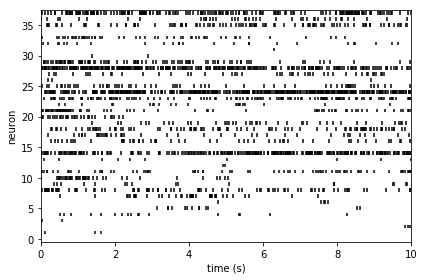

In [3]:

raster=data1
tmin=np.min(raster[:,0])
tmax=np.max(raster[:,0])
plt.xlim([0,10])
plt.ylim([-0.5,37.5])
plt.vlines((raster[:,0]-tmin)/10000,raster[:,1]-0.3,raster[:,1]+0.3)
plt.xlabel('time (s)')
plt.ylabel('neuron')
#plt.title('Raster plot')
plt.tight_layout()
plt.savefig('raster_task_dt01t1sec.pdf')
plt.show()


Question 2:  Functions to extract from data the neural activity matrix and the zscore matrix. 

In [5]:
#Function smat: LxM activity matrix from the data. Gives the number of spikes at each time bin [n=1..M] for each neuron [i=1...38] 
    #time window of a bin (data are in 0.1 ms) dt=100 ms 
def smat(data):

    dt=1000 
    L=np.amax(data[:,1]).astype(int)
    Ndata=np.size(data,0);
    Tmin=np.amin(data[:,0])
    Tmax=np.amax(data[:,0])
    T=Tmax-Tmin
    M=int(T//dt)+1
    #y bin in which the neuron is active
    y=(data[:,0]-Tmin)/dt
    #x index of active neuron (starting from zero) 
    x=(data[:,1])-1
    z=np.ones(Ndata)
    s_sparse=coo_matrix((z,(x,y)),dtype=np.int8,shape=(L,M))
    s=s_sparse.toarray()
    #Alternative way without using sparse matrices
    #s=np.zeros((L,M),dtype=int)
    #for k in range(len(data)):
    #    s[data[k,1]-1,(data[k,0]-Tmin)//dt]+=1
    return s

In [6]:
#Function Zscore: calculation of z-score from the data
def Zscore(data):
    dt=1000 
    Tmin=np.amin(data[:,0])
    Tmax=np.amax(data[:,0])
    T=Tmax-Tmin
    M=int(T//dt)+1
    s=smat(data)
    f=np.mean(s,1)
    sigma=np.std(s, axis=1, dtype=np.float64, ddof=1)
    #s.T same as np.transpose(s) 
    #y is a matrix M x L to adapt to the usual data format
    y=(s.T-f)/sigma 
    return y.astype(np.float64)
    #return y




Question 2: Compute Pearson matrix for data and diagonalize it. Compare the spectrum to the Marcenko Pastur distribution to extract the signal components associated to large eigenvalues.

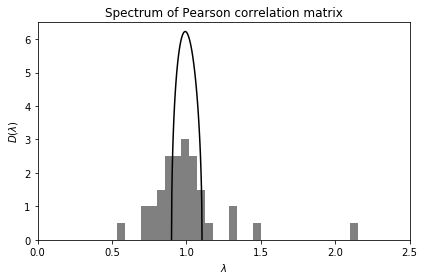

Number of eigenvalues > lp:  6


In [7]:

Y=Zscore(datatask)
C=np.dot(Y.T,Y)/np.size(Y,0)
w, v = LA.eig(C)

#plot eigenvalue distribution
r=np.size(Y,1)/np.size(Y,0)
lp=(1+np.sqrt(r))**2
lm=(1-np.sqrt(r))**2
x=np.zeros((2,101))
for i in range(101):
    t=lm+(lp-lm)*i/100
    x[0,i]=t
    x[1,i]=np.sqrt((lp-t)*(t-lm))/(t*r)/(2*math.pi)
plt.hist(w, bins=30, density=True, facecolor='grey')
plt.plot(x[0,:],x[1,:],'black')
plt.xlim([0,2.5])
plt.ylim([0,6.5])
plt.xlabel('$\lambda$')
plt.ylabel('$D(\lambda)$')
#plt.text(2.3, 6., 'A', fontweight='bold')
plt.title('Spectrum of Pearson correlation matrix')
plt.tight_layout()
#plt.savefig('PCA-task.pdf')
plt.show()


print('Number of eigenvalues > lp: ',len(np.where(w>lp)[0]))

Question 3: Same as question 2 by reshuffling the spike times for each neuron.

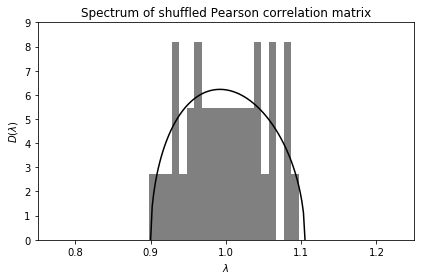

In [8]:
#Question 3: reshuffling the matrix
Yshuffle=np.copy(Y)
for i in range(np.size(Y,1)):
    np.random.shuffle(Yshuffle[:,i])

Cshuffle=np.dot(Yshuffle.T,Yshuffle)/np.size(Yshuffle,0)
ws, vs = LA.eig(Cshuffle)

#plot eigenvalue distribution
r=np.size(Yshuffle,1)/np.size(Yshuffle,0)
lp=(1+np.sqrt(r))**2
lm=(1-np.sqrt(r))**2
x=np.zeros((2,101))
for i in range(101):
    t=lm+(lp-lm)*i/100
    x[0,i]=t
    x[1,i]=np.sqrt((lp-t)*(t-lm))/(t*r)/(2*math.pi)
plt.hist(ws, bins=20, density=True, facecolor='grey')
plt.plot(x[0,:],x[1,:],'black')
plt.xlim([0.75,1.25])
plt.ylim([0,9])
plt.xlabel('$\lambda$')
plt.ylabel('$D(\lambda)$')
#plt.text(1.21, 8.2, 'B', fontweight='bold')
plt.title('Spectrum of shuffled Pearson correlation matrix')
plt.tight_layout()
#plt.savefig('PCA-task-reshuffled.pdf')
plt.show()


Question 4: Find the neurons that contribute the most to the principal component in the task.

2.1505329296819298 
 [-0.30575564  0.011962    0.00778311  0.00506386 -0.00252716 -0.01322397
 -0.09040398 -0.16575109 -0.27394546 -0.16083999 -0.16557683 -0.00855851
 -0.0309192   0.18770264  0.01711809 -0.10031741  0.13603484 -0.19069276
  0.03161871 -0.48857061 -0.42966552 -0.00084054 -0.07465402  0.09245687
 -0.10297825 -0.29401518  0.22419096 -0.06819083 -0.11757315  0.00927365
 -0.01872674 -0.09513298  0.01027532  0.05442999 -0.12028375  0.02597055
 -0.09338114]


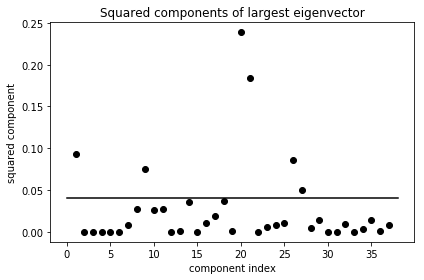

[ 1  9 20 21 26 27]


In [9]:
v0=np.copy(v[:,0])
print(w[0],'\n',v0)
plt.plot(np.arange(1,v0.shape[0]+1),v0**2,'ko')
plt.plot([0,v0.shape[0]+1],[0.2**2,0.2**2],'black')
plt.title('Squared components of largest eigenvector')
plt.xlabel('component index')
plt.ylabel('squared component')
plt.tight_layout()
#plt.savefig('taskcellassembly.pdf')
plt.show()
print(np.where(abs(v0)>0.2)[0]+1)

Question 5: Computhe the total replay of the Sleep Pre and Sleep Post epochs.

In [10]:
Ypre=Zscore(datapre)
Cpre=np.dot(Ypre.T,Ypre)/np.size(Ypre,0)
Ypost=Zscore(datapost)
Cpost=np.dot(Ypost.T,Ypost)/np.size(Ypost,0)

I=np.identity(np.size(Y,1))

Rpre = .5 * np.trace( np.dot((Cpre-I),(C-I)) )
Rpost = .5 * np.trace( np.dot((Cpost-I),(C-I)) )

print(Rpre,Rpost)

0.2907080442794275 0.5480941612056786


Question 6: Plot the Reactivation of the first component over time in Sleep Pre and in Sleep Post.  

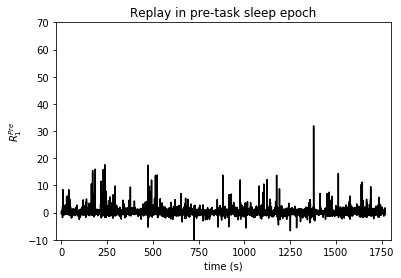

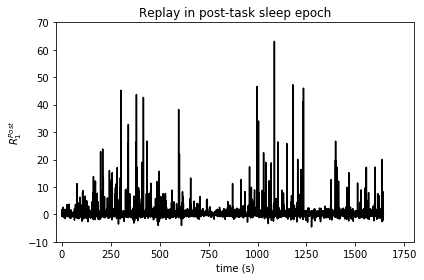

In [11]:

dt=100

Rtpre = .5 * ( np.square(np.dot(Ypre,v0)) -  np.sum(np.square(Ypre*v0),axis=1) )
Rtpost = .5 * ( np.square(np.dot(Ypost,v0)) -  np.sum(np.square(Ypost*v0),axis=1) )
timepre=np.arange(1,np.size(Rtpre)+1)*dt/1000
timepost=np.arange(1,np.size(Rtpost)+1)*dt/1000

plt.plot(timepre[:],Rtpre[:],'k')
plt.title('Replay in pre-task sleep epoch')
plt.xlabel('time (s)')
plt.ylabel('$R_1^{Pre}$')
plt.xlim([-30,1800])
plt.ylim([-10,70])
#plt.text(1700, 62, 'A', fontweight='bold')
#plt.tight_layout()
#plt.savefig('RTSleepPre.pdf')
plt.show()
plt.plot(timepost[:],Rtpost[:],'k')
plt.title('Replay in post-task sleep epoch')
plt.xlabel('time (s)')
plt.ylim([-10,70])
plt.xlim([-30,1800])
plt.ylabel('$R_1^{Post}$')
#plt.text(1700, 62, 'B', fontweight='bold')
plt.tight_layout()
#plt.savefig('RTSleepPost.pdf')
plt.show()


Question 7 (Bonus): Plot the Reactivation of each component as a function of its eigenvalue. Plot the scatter of the reactivations of the components of the Sleep Post and Sleep Pre.

Component 0 (pre and post):  0.12020905160974804 0.26578040826001803
Component 1 (pre and post):  0.009740569594089834 0.028434550395715165
Test:  0.29070797006986937 0.5480940812640627


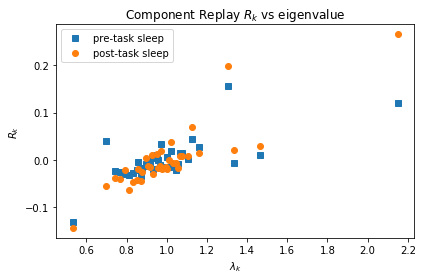

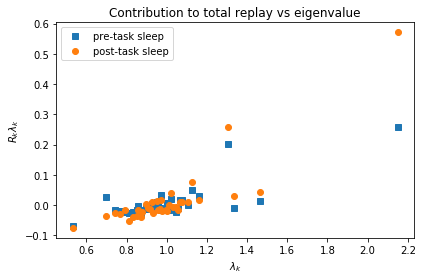

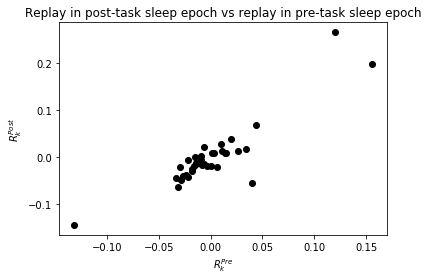

In [12]:


R0Pre = np.mean(.5 * ( np.square(np.dot(Ypre,v0)) -  np.sum(np.square(Ypre*v0),axis=1) ))
R0Post = np.mean(.5 * ( np.square(np.dot(Ypost,v0)) -  np.sum(np.square(Ypost*v0),axis=1) ))

print('Component 0 (pre and post): ',R0Pre,R0Post)

v1=np.copy(v[:,1])
R1Pre = np.mean(.5 * ( np.square(np.dot(Ypre,v1)) -  np.sum(np.square(Ypre*v1),axis=1) ))
R1Post = np.mean(.5 * ( np.square(np.dot(Ypost,v1)) -  np.sum(np.square(Ypost*v1),axis=1) ))

print('Component 1 (pre and post): ',R1Pre,R1Post)

Rcpre = np.zeros(np.size(Y,1))
Rcpost = np.zeros(np.size(Y,1))
testRPretot=0
testRPosttot=0
for k in range(np.size(Y,1)):
    vk=np.copy(v[:,k])
    Rcpre[k] = np.mean(.5 * ( np.square(np.dot(Ypre,vk)) -  np.sum(np.square(Ypre*vk),axis=1) ))
    Rcpost[k] = np.mean(.5 * ( np.square(np.dot(Ypost,vk)) -  np.sum(np.square(Ypost*vk),axis=1) ))
    testRPretot += (w[k]*Rcpre[k])
    testRPosttot += (w[k]*Rcpost[k])

print('Test: ',testRPretot,testRPosttot)

#plt.plot(w[:],Rcpre[:],'ks',label='pre-task sleep',color='')
#plt.plot(w[:],Rcpost[:],'ko',label='post-task sleep')
plt.plot(w[:],Rcpre[:],'s',label='pre-task sleep')
plt.plot(w[:],Rcpost[:],'o',label='post-task sleep')

plt.title('Component Replay $R_k$ vs eigenvalue')
plt.xlabel('$\lambda_k$')
plt.ylabel('$R_k$')
plt.legend()
plt.tight_layout()
#plt.savefig('Rvslambda.pdf')
plt.show()
#plt.plot(w[:],(w*Rcpre)[:],'ks',label='pre-task sleep')
#plt.plot(w[:],(w*Rcpost)[:],'ko',label='post-task sleep')

plt.plot(w[:],(w*Rcpre)[:],'s',label='pre-task sleep')
plt.plot(w[:],(w*Rcpost)[:],'o',label='post-task sleep')
plt.title('Contribution to total replay vs eigenvalue')

plt.xlabel('$\lambda_k$')
plt.ylabel('$R_k \lambda_k$')
plt.legend()
plt.tight_layout()
#plt.savefig('Rvslambda.pdf')
plt.show()
#plt.plot(Rcpre[:],Rcpost[:],'ko')
plt.plot(Rcpre[:],Rcpost[:],'ko')
plt.title('Replay in post-task sleep epoch vs replay in pre-task sleep epoch')
plt.xlabel('$R^{Pre}_k$')
plt.ylabel('$R^{Post}_k$')
plt.tight_layout()
#plt.savefig('RpostvsRpre.pdf')
plt.show()